In [1]:
#since noteboke doesn't work in jupiterlabs    %matplotlib notebook 
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import os
# os.environ['PATH'] += os.pathsep + 'D:\\6OHDA\\'
import numpy as np
import scipy as sci
from IO import *
from utils import *
import re
from tqdm import tqdm

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate
from tensorflow.keras.layers import Convolution2D, MaxPooling2D,Conv2D, Conv1D,MaxPooling1D
# from tensorflow.keras.layers.core import Lambda
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import pickle
import random

import PIL
from PIL import Image 

# import png

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.config.list_physical_devices()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8572020547609250095
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10540119401043995362
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 868534930029282134
physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5']
#miceList.remove('1253')
#miceList.remove('1231')
def periodCalc(day):
    if day== 0:
        return 'Healthy'
    elif day<13:
        return 'Acute' #day 1-13
    else:
        return 'Chronic' #day 14-35

In [ ]:
def center(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

f = h5py.File('D:\\6OHDA\\Spectograms.hdf5','r') 
df = pd.DataFrame(columns= ["Mouse","Session","Period","length"])
for m in getMiceList(Files[0]):
    data =  getData(Files[0],['speed','trace'],period ='Pre', mice=m)
    for sess in data.keys():
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        freq = f[m][sess]['Pre']['freq'][:]
        coeff = f[m][sess]['Pre']['coeff'][:].shape
        
        df = df.append({"Mouse":m,"Session":sess,'Period':periodCalc(day),"length":np.max(coeff),"freq":freq},ignore_index=True)
        
df.to_csv('availableData_LFPwavelet.csv')  
f.close()

In [5]:
def prepData(segN,overlap,df):
    df2 = df
    df2['start'] = pd.Series([[]] * len(df2), index=df2.index)
    df2['end'] = pd.Series([[]] * len(df2), index=df2.index)
    for l in df.length.unique():
        a = np.asarray([[i,i + segN] for i in range(0, l-(segN-overlap),int(segN-overlap))])
        df2.loc[df2.length==l,'start'] = pd.Series([a[:,0]] * len(df2), index=df2.index)
        df2.loc[df2.length==l,'end'] =  pd.Series([a[:,1]] * len(df2), index=df2.index)
    lst_col = 'start'

    lst_col = 'start'
    lst_col2 = 'end'
    df3 = pd.DataFrame({
        col:np.repeat(df2[col].values, df2['start'].str.len())
        for col in df2.columns.difference(['start','end'])
    }).assign(**{'start':np.concatenate(df2['start'].values)}).assign(**{'end':np.concatenate(df2['end'].values)})[df2.columns.tolist()]
    return df3

In [6]:
miceList = getMiceList(Files[0])
miceList.remove('1253') # only healthy data - must be in training
miceList.remove('1231') # only healthy data - must be in training
miceList.remove('8430') # very abnormal running behavour
mOrder = np.random.permutation(len(miceList))

mTrain = [1231, 1253]
mTest =[int(miceList[i]) for i in mOrder[:2]]
mTrain = mTrain+ [int(miceList[i]) for i in mOrder[2:]]

print(mTrain,mTest)

[1231, 1253, 7909, 2981, 1236, 7584, 8803, 761, 2976, 1208, 1793, 8815, 1222] [2980, 4539]


In [6]:
mTrain = [1231, 1253, 7909, 1236, 761, 1793, 1222, 2980, 7584, 8803, 1208, 2981, 4539] 
mTest = [8815, 2976]

In [204]:
import gc
for obj in gc.get_objects():   # Browse through ALL objects
    if isinstance(obj, h5py.File):   # Just HDF5 files
        try:
            obj.close()
        except:
            pass # Was already closed

In [205]:
with h5py.File('E:\\Spectograms_norm.hdf5','a') as f:
    for i in f.keys():
        try:
            dp = f[i]['data2'][:]
            mi = np.min(dp[:,:,0])
            ma = np.max(dp[:,:,0])
            dp = 255*(dp-mi)/(ma-mi)
            del f[i]['data2'] 
            f[i]['data2'] = dp
        except:
            print(i)
            continue


1208_day12
2976_day4


In [18]:
df = pd.read_csv('availableData_LFPwavelet.csv')  
# # try 30s with 20s overlab
dtL =  0.00032768
segN = int(np.ceil(5/dtL))
# overlap = int(np.ceil(1/dtL))
# # dataSamples = prepData(segN,overlap,df)

# df = prepData(segN,overlap,df)
# print(len(df))
# drop = []
# with h5py.File('E:\\Spectograms_norm.hdf5','r') as f:
#     dictData = df.to_dict('records')
#     for i in range(len(dictData)):
#         dp = f[dictData[i]['Session']]['data'][dictData[i]['start']:dictData[i]['end'],0:87]
#         if dp.shape != (segN,87):
#             drop.append(i)
# df = df.drop(drop)
# print(len(df))
# # df.to_csv('availableData_LFPwavelet_5s3overlap.csv')  

df = pd.read_csv('availableData_LFPwavelet_5s3overlap.csv')
def Clabel(x):
    if x=='Healthy':
        return [1,0,0]
    elif x=='Acute':
        return [0,1,0]
    else:
        return [0,0,1]


df['label'] = df.apply(lambda x: Clabel(x.Period), axis=1 )

testData = df[df.Mouse.isin(mTest)]
trainData = df[df.Mouse.isin(mTrain)]
validate = trainData.sample(frac=.1)
trainData = trainData.drop(validate.index)

In [19]:
print(len(trainData),len(validate),len(testData))

22053 2450 4884


In [16]:
trainData

,Unnamed: 0,Unnamed: 0.1,Mouse,Session,Period,length,freq,start,end,label
0,0,0,761,0761_BaselineA,Healthy,1815677,[ 4.99742 5.99952388 6.99944452 7.98...,0,15259,"[1, 0, 0]"
1,1,0,761,0761_BaselineA,Healthy,1815677,[ 4.99742 5.99952388 6.99944452 7.98...,12207,27466,"[1, 0, 0]"
2,2,0,761,0761_BaselineA,Healthy,1815677,[ 4.99742 5.99952388 6.99944452 7.98...,24414,39673,"[1, 0, 0]"
3,3,0,761,0761_BaselineA,Healthy,1815677,[ 4.99742 5.99952388 6.99944452 7.98...,36621,51880,"[1, 0, 0]"
4,4,0,761,0761_BaselineA,Healthy,1815677,[ 4.99742 5.99952388 6.99944452 7.98...,48828,64087,"[1, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...
31306,31307,211,8815,8815_day8,Acute,1815793,[ 4.99742 5.99952388 6.99944452 7.98...,1745601,1760860,"[0, 1, 0]"
31307,31308,211,8815,8815_day8,Acute,1815793,[ 4.99742 5.99952388 6.99944452 7.98...,1757808,1773067,"[0, 1, 0]"
31308,31309,211,8815,8815_day8,Acute,1815793,[ 4.99742 5.99952388 6.99944452 7.98...,1770015,1785274,"[0, 1, 0]"
31309,31310,211,8815,8815_day8,Acute,1815793,[ 4.99742 5.99952388 6.99944452 7.98...,1782222,1797481,"[0, 1, 0]"


In [396]:
dataVersion = 'v1_n_wavelet'
#save data partition: 
trainData.to_csv('dataPartition_'+dataVersion+'_train.csv')
validate.to_csv('dataPartition_'+dataVersion+'_val.csv')
testData.to_csv('dataPartition_'+dataVersion+'_test.csv')

In [9]:
def loadTrain(data,butchSize):
    with h5py.File('E:\\Spectograms_norm.hdf5','r') as f:
    # sampleSize = batchSize/3
        while True: 
            data = data.sample(frac=1)
            dictData = data.to_dict('records')
            for i in range(0,len(dictData)-butchSize,butchSize):
                labels = [dictData[i]['label'] for i in range(i,i+butchSize)]
                dp = [f[dictData[i]['Session']]['data2'][dictData[i]['start']:dictData[i]['end']:10,0:87] for i in range(i,i+butchSize)]
                dp = [np.array(Image.fromarray(i.astype(np.uint8)).resize((224, 224), PIL.Image.BICUBIC)) for i in dp]
                labels = np.stack(labels)
                dataPoint = np.stack(dp)
                yield (dataPoint,labels)
                labels = []
                dataPoint = []
            


In [10]:
def loadTest(data,butchSize):
    with h5py.File('E:\\Spectograms_norm.hdf5','r') as f:
    # sampleSize = batchSize/3
        dictData = data.to_dict('records')
        for i in range(0,len(dictData)-butchSize,butchSize):
            labels = [dictData[i]['label'] for i in range(i,i+butchSize)]
            dp = [f[dictData[i]['Session']]['data2'][dictData[i]['start']:dictData[i]['end']:10,0:87] for i in range(i,i+butchSize)]
            dp = [np.array(Image.fromarray(i.astype(np.uint8)).resize((224, 224), PIL.Image.BICUBIC)) for i in dp]
            labels = np.stack(labels)
            dataPoint = np.stack(dp)
            yield (dataPoint,labels)
            labels = []
            dataPoint = []


In [61]:
def loadTest(data,butchSize):
    with h5py.File('E:\\Spectograms_norm.hdf5','r') as f:
    # sampleSize = batchSize/3
        dictData = data.to_dict('records')
        for i in range(0,len(dictData)-butchSize,butchSize):
            labels = [dictData[i]['Period'] for i in range(i,i+butchSize)]
            dp = [f[dictData[i]['Session']]['data'][dictData[i]['start']:dictData[i]['end'],0:87] for i in range(i,i+butchSize)]
            labels = np.stack(labels)
            dataPoint =np.repeat(np.stack(dp)[:,:,:,np.newaxis], 3, -1) 
            yield (dataPoint,labels)
            labels = []
            dataPoint = []

def loadTest2(data,butchSize):
    with h5py.File('E:\\Spectograms_norm.hdf5','r') as f:
    # sampleSize = batchSize/3
        dictData = data.to_dict('records')
        for i in range(0,len(dictData)-butchSize,butchSize):
            labels = [dictData[i]['Period'] for i in range(i,i+butchSize)].
            dp = [f[dictData[i]['Session']]['data2'][dictData[i]['start']:dictData[i]['end'],0:87] for i in range(i,i+butchSize)]
            labels = np.stack(labels)
            dataPoint = np.stack(dp)
            yield (dataPoint,labels)
            labels = []
            dataPoint = []

# y = []
# for ind,(dataP,label) in tqdm(enumerate(loadTest(testData,butchSize))):
#     y = y+list(label)

y = []
for ind,(dataP,label) in tqdm(enumerate(loadTest2(testData.loc[:600],butchSize))):
    y = y+list(label)


8it [01:46, 13.32s/it]
8it [01:39, 12.45s/it]


In [11]:
butchSize = 25
for ind,(dataP,label) in enumerate(loadTest(testData,butchSize)):
    print(label.shape,dataP.shape)#,np.max(dataP),np.min(dataP))
    if ind == 1:
        break

(25, 3) (25, 224, 224, 3)
(25, 3) (25, 224, 224, 3)


In [12]:
for ind,(dataP,label) in enumerate(loadTrain(validate,butchSize)):
    print(label.shape,dataP.shape)#,sci.stats.pearsonr(np.mean(dataP[:,:,0],axis=1), label))
#     plt.scatter(np.mean(dataP[:,:,0],axis=1), label)
    if ind == 2:
        break        

(25, 3) (25, 224, 224, 3)
(25, 3) (25, 224, 224, 3)
(25, 3) (25, 224, 224, 3)


In [31]:
del model  

In [12]:
inputs = tf.keras.Input(shape=(segN//10+1, 87, 3))
base_model = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
#     input_shape=(segN//10+1, 87, 3),
#     pooling=None,
#     classes=3,
    classifier_activation="softmax",
)#(inputs)
base_model.trainable = False

x= base_model.layers[-3].output
# x = base_model(inputs, training=False)
# x = tf.keras.layers.Flatten(name='newFlat')(x)
# x = tf.keras.layers.Dense(120, activation='relu')(x) 
# x = tf.keras.layers.Dense(120, activation='relu')(x) 
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
model = tf.keras.Model(base_model.input, outputs)


In [13]:
print(model.summary())
# outputs

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [498]:
import keras_tuner as kt
from keras_tuner import HyperModel as hp
from keras_tuner.tuners import RandomSearch


In [14]:
modelName = 'wavelet_VGG16_n2_AcuteVsHealthy'
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=50,
    mode='max',
    restore_best_weights=False)

check_point = tf.keras.callbacks.ModelCheckpoint(
    'E:\\'+modelName+'_bestWeights.h5',
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch"
)

In [23]:
trainData2 = trainData[trainData.Period!='Chronic']
trainData2 = trainData2.groupby('Period').sample(10332,replace=True)

validate2 = validate[validate.Period!='Chronic']
validate2 = validate2.groupby('Period').sample(1147,replace=True)

def Clabel(x):
    if x=='Healthy':
        return [1,0]
    else:
        return [0,1]



validate2['label'] = validate2.apply(lambda x: Clabel(x.Period), axis=1 )
trainData2['label'] = trainData2.apply(lambda x: Clabel(x.Period), axis=1 )

In [24]:
batchSize = 25
modelName = 'wavelet_VGG16_n2_AcuteVsHealthy2'

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# model.load_weights('E:\\'+modelName+'_bestWeights.h5')

stepTrain=len(trainData2)//batchSize
stepValidate=len(validate2)//batchSize

history = model.fit(loadTrain(trainData2,batchSize),
                    steps_per_epoch=stepTrain,
                    validation_data=loadTrain(validate2,batchSize),
                    validation_steps=stepValidate,
                    epochs=3000,callbacks=[early_stopping,check_point],verbose=1)#,


Epoch 1/3000
826/826 [==============================] - 2088s 3s/step - loss: 0.8280 - accuracy: 0.5764 - val_loss: 1.0369 - val_accuracy: 0.5451

Epoch 00001: val_accuracy improved from -inf to 0.54505, saving model to E:\wavelet_VGG16_n2_AcuteVsHealthy_bestWeights.h5
Epoch 2/3000
826/826 [==============================] - 1052s 1s/step - loss: 0.7194 - accuracy: 0.6230 - val_loss: 0.6802 - val_accuracy: 0.6000

Epoch 00002: val_accuracy improved from 0.54505 to 0.60000, saving model to E:\wavelet_VGG16_n2_AcuteVsHealthy_bestWeights.h5
Epoch 3/3000
826/826 [==============================] - 1046s 1s/step - loss: 0.6484 - accuracy: 0.6530 - val_loss: 0.7776 - val_accuracy: 0.5864

Epoch 00003: val_accuracy did not improve from 0.60000
Epoch 4/3000
826/826 [==============================] - 1043s 1s/step - loss: 0.6442 - accuracy: 0.6678 - val_loss: 1.0930 - val_accuracy: 0.5609

Epoch 00004: val_accuracy did not improve from 0.60000
Epoch 5/3000
826/826 [==============================]

826/826 [==============================] - 1011s 1s/step - loss: 0.5180 - accuracy: 0.7644 - val_loss: 1.0913 - val_accuracy: 0.6180

Epoch 00040: val_accuracy did not improve from 0.61978
Epoch 41/3000
826/826 [==============================] - 1011s 1s/step - loss: 0.5218 - accuracy: 0.7664 - val_loss: 1.1621 - val_accuracy: 0.5675

Epoch 00041: val_accuracy did not improve from 0.61978
Epoch 42/3000
826/826 [==============================] - 1012s 1s/step - loss: 0.5482 - accuracy: 0.7570 - val_loss: 0.9947 - val_accuracy: 0.6026

Epoch 00042: val_accuracy did not improve from 0.61978
Epoch 43/3000
826/826 [==============================] - 1003s 1s/step - loss: 0.5123 - accuracy: 0.7692 - val_loss: 1.0169 - val_accuracy: 0.6022

Epoch 00043: val_accuracy did not improve from 0.61978
Epoch 44/3000
826/826 [==============================] - 1003s 1s/step - loss: 0.5082 - accuracy: 0.7716 - val_loss: 1.0576 - val_accuracy: 0.5815

Epoch 00044: val_accuracy did not improve from 0.61978

In [592]:
## Saving the model
##
model.save('E:\\'+modelName)
model.save_weights('E:\\'+modelName+'_weights.h5')

INFO:tensorflow:Assets written to: E:\rawLFP_v5n_tunning_binary\assets


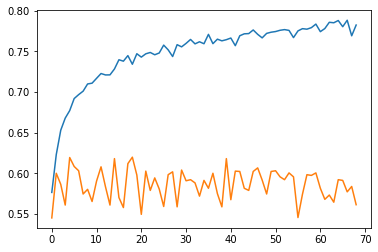

In [25]:
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])# history.history
plt.savefig("E:\\NN\\"+modelName+"_history.png")

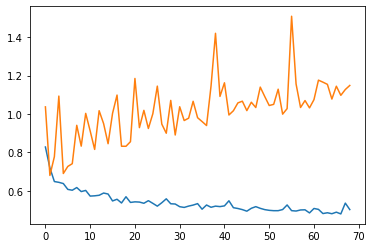

In [26]:
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])# history.history
plt.savefig("E:\\NN\\"+modelName+"_loss.png")

In [593]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")

# labels = (train_generator.class_indices)
pred = model.predict_generator(loadTest(testData),verbose=1)
pred = np.argmax(pred,axis=1)
print(np.unique(pred))

y = []
for ind,(dataP,label) in enumerate(loadTest(testData)):
    y = y+list(np.argmax(label,axis=1))
# print(pred[1:100],y[1:100])

      1/Unknown - 0s 156ms/step

C:\Users\dzemel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


153/153 [==============================] - 1s 5ms/step
[0 1]


0.7702407002188184


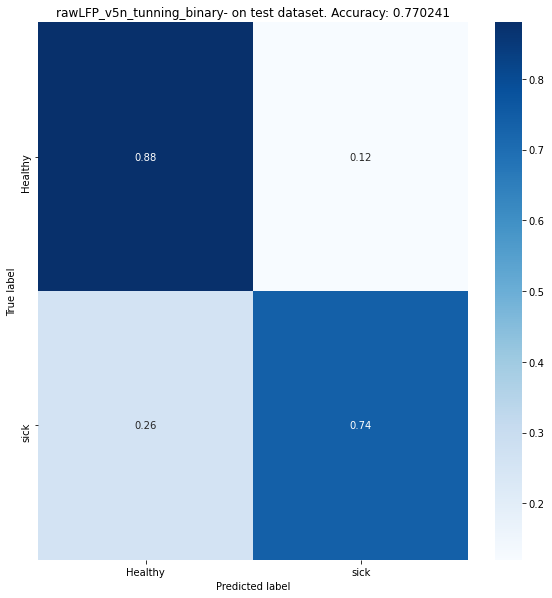

In [595]:
classes=['Healthy','sick']
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title(modelName +"- on test dataset. Accuracy: {acc:f}".format(acc=np.sum(y==pred)/len(y)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("E:\\NN\\"+modelName+"_confusionOnTest_Test.png")
print(np.sum(y==pred)/len(y))

In [28]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")

# labels = (train_generator.class_indices)
pred = model.predict_generator(loadTest(validate,batchSize),verbose=1)
pred = np.argmax(pred,axis=1)
print(np.unique(pred))

y = []
for ind,(dataP,label) in enumerate(loadTest(validate,batchSize)):
    y = y+list(np.argmax(label,axis=1))
# print(pred[1:100],y[1:100])

C:\Users\dzemel\Miniconda3\envs\LSTM\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


101/101 [==============================] - 50s 496ms/step
[0 1 2]


0.43564356435643564


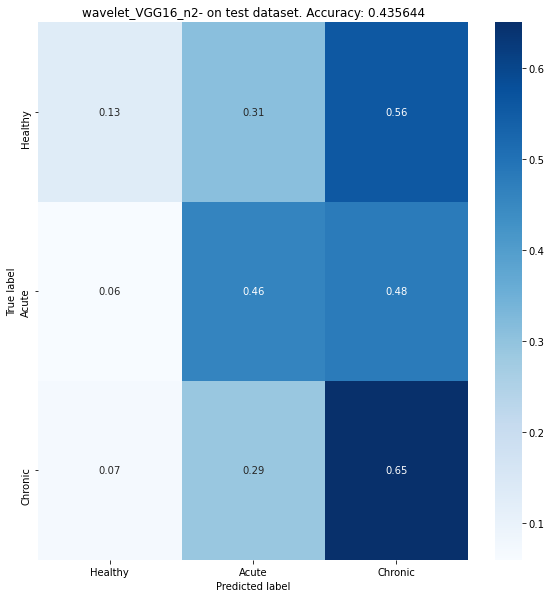

In [29]:
classes=['Healthy','Acute','Chronic']
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title(modelName +"- on test dataset. Accuracy: {acc:f}".format(acc=np.sum(y==pred)/len(y)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("E:\\NN\\"+modelName+"_confusionOnTest_val.png")
print(np.sum(y==pred)/len(y))

In [161]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")

# labels = (train_generator.class_indices)
pred = model.predict_generator(loadTest(trainData2,batchSize),verbose=1)
pred = np.argmax(pred,axis=1)
print(np.unique(pred))

y = []
for ind,(dataP,label) in enumerate(loadTest(trainData2,batchSize)):
    y = y+list(np.argmax(label,axis=1))
# print(pred[1:100],y[1:100])

24/24 [==============================] - 2s 100ms/step
[0]


0.21354166666666666


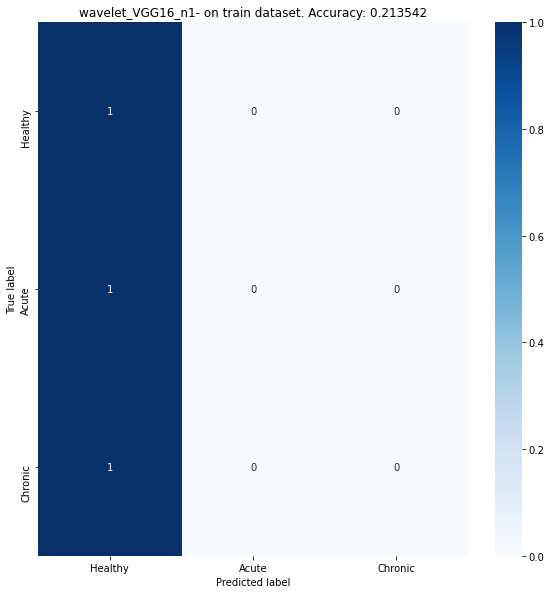

In [162]:
classes=['Healthy','Acute','Chronic']
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title(modelName +"- on train dataset. Accuracy: {acc:f}".format(acc=np.sum(y==pred)/len(y)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("E:\\NN\\"+modelName+"_confusionOnTest_Train.png")
print(np.sum(y==pred)/len(y))

In [71]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")

# train_datagenT = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# train_generatorT = train_datagenT.flow_from_directory(
#     directory="E:\\data\\Train\\",#'E:\\data\\imageTest\\training_set\\',#
#     target_size=(300, 300),
#     color_mode="grayscale",
#     batch_size=32,
#     class_mode="categorical",
#     shuffle=False,
#     seed=36
# )


labels = (train_generator.class_indices)
pred = model.predict_generator(train_generatorT,verbose=1)
pred = np.argmax(pred,axis=1)
print(np.unique(pred))

y = []
for f in train_generatorT.filenames:
    sess = f.split("_")[1]
    if sess[0] == 'B':
        day = 0
    else:
        day = int(re.findall(r'\d+',sess)[0])

    # get data
    period = periodCalc(day) 
    y.append(labels[period])

567/567 [==============================] - 89s 157ms/step
[0 1 2]


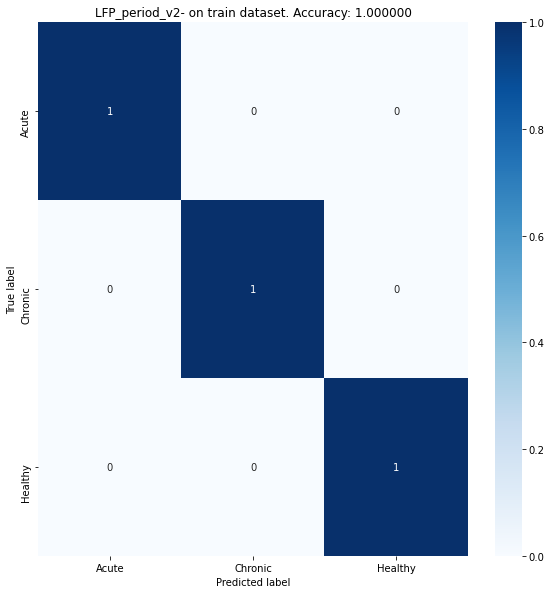

In [73]:
classes=labels.keys()
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title(modelName +"- on train dataset. Accuracy: {acc:f}".format(acc=np.sum(y==pred)/len(y)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("E:\\NN\\"+modelName+"_confusionOnTest_Train.png")


In [61]:
score = model.evaluate(train_generatorT)
print(score)

567/567 [==============================] - 89s 157ms/step - loss: 3.5345e-04 - accuracy: 1.0000
[0.00035344576463103294, 1.0]


In [56]:
pred = model.predict_generator(train_generator,verbose=1)
pred.shape

567/567 [==============================] - 89s 157ms/step


(18130, 3)

In [57]:
train_generatorT = train_datagen.flow_from_directory(
    directory="E:\\data\\Train\\",#'E:\\data\\imageTest\\training_set\\',#
    target_size=(300, 300),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=36
)


array([[9.9993336e-01, 6.6623645e-05, 2.0047966e-09],
       [1.0000000e+00, 1.3673330e-08, 4.0443326e-10],
       [3.7493074e-08, 1.0000000e+00, 1.9402356e-11],
       [3.0466440e-04, 9.9913293e-01, 5.6242698e-04]], dtype=float32)

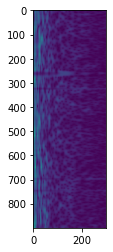

In [85]:
%matplotlib inline
for d,l in train_generator:
    plt.imshow(d[16,:,:,0])
    break